In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
%matplotlib inline

In [2]:
default = pd.read_csv('credit_card_data.csv')
default.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
pandas_profiling.ProfileReport(default)

Number of variables,25
Number of observations,30000
Total Missing (%),0.0%
Total size in memory,5.7 MiB
Average record size in memory,200.0 B
Numeric,18
Categorical,0
Boolean,2
Date,0
Text (Unique),0
Rejected,5


In [4]:
default.drop(columns=['ID'], inplace =True)
default.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [5]:
default.rename(columns = lambda x : x.lower(), inplace=True)

In [6]:
default['grad_school'] = (default['education'] == 1).astype('int')
default['university'] = (default['education'] == 2).astype('int')
default['high_school'] = (default['education'] == 3).astype('int')
default.drop('education', axis=1, inplace=True)

In [7]:
default['male'] = (default['sex'] == 1).astype('int')
default.drop('sex', axis=1, inplace=True)

In [8]:
default['married'] = (default['marriage'] == 1).astype('int')
default.drop('marriage', axis=1, inplace=True)

In [9]:
pay_features = ['pay_0', 'pay_2','pay_3','pay_4','pay_5','pay_6', ]
for p in pay_features:
    default.loc[default[p]<= 0, p] = 0
    
default.rename(columns={'default.payment.next.month':'default'}, inplace =True)

In [10]:
default.shape

(30000, 26)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import RobustScaler

In [12]:
X = default.drop('default', axis=1)
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = default['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
def CMatrix(CM, labels=['pay','default']):
    df = pd.DataFrame(data = CM, index=labels, columns =labels)
    df.index.name='TRUE'
    df.columns.name='PREDICTION'
    df.loc['Total']=df.sum()
    df['Total'] = df.sum(axis=1)
    return df

In [14]:
metrics = pd.DataFrame(index=['accuracy','precision','recall'],
                      columns=['NULL', 'LogisticReg','ClassTree','NaiveBayes'])

In [15]:
from xgboost import XGBClassifier

In [16]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train,y_train)
y_pred_xgb = xgb_classifier.predict(X_test)

In [17]:
confusion_matrix(y_test,y_pred_xgb)

array([[4437,  236],
       [ 849,  478]], dtype=int64)

In [18]:
accuracy_score(y_test,y_pred_xgb)*100

81.91666666666667

In [19]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.67      0.36      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



In [20]:
precision_xg, recall_xg, thresholds_xg = precision_recall_curve(y_true=y_test, probas_pred = xgb_classifier.predict_proba(X_test)[:,1])

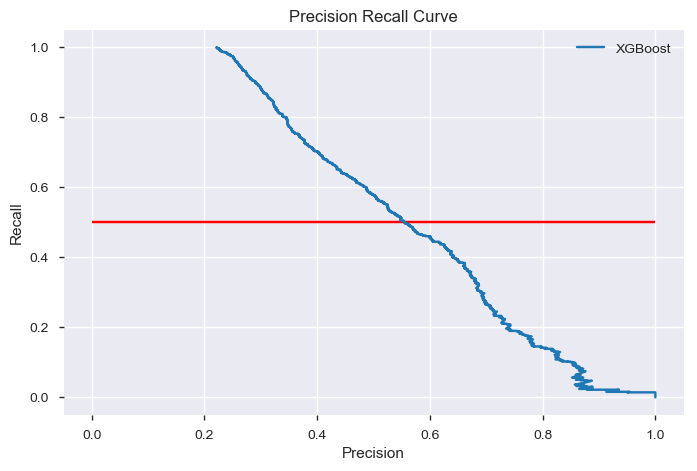

In [52]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(precision_xg,recall_xg, label='XGBoost')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision Recall Curve')
ax.hlines(y=0.5, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid(b=True, which='minor', color='b', linestyle='-')

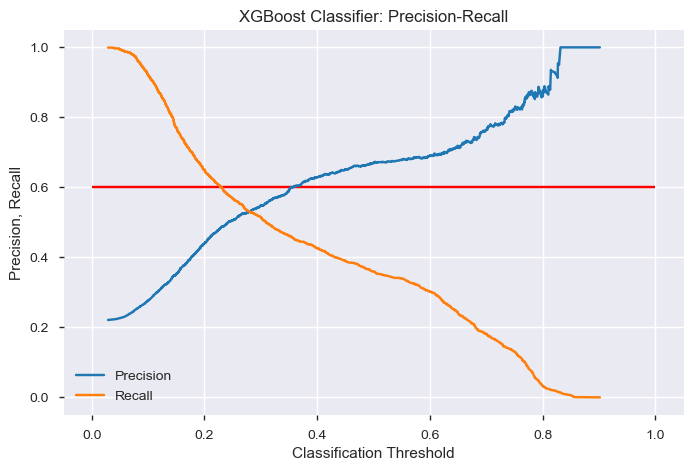

In [54]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(thresholds_xg,precision_xg[1:], label='Precision')
ax.plot(thresholds_xg,recall_xg[1:], label='Recall')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Precision, Recall')
ax.set_title('XGBoost Classifier: Precision-Recall')
ax.hlines(y=0.6, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid(b=True, which='minor', color='b', linestyle='-')


In [47]:
y_pred_proba = xgb_classifier.predict_proba(X_test)[:,1]
y_pred_test = (y_pred_proba >= 0.2).astype('int')
#confusion Matrix
CM = confusion_matrix(y_pred = y_pred_test, y_true=y_test)
print('Recall: ', 100*recall_score(y_pred=y_pred_test, y_true=y_test))
print('Precision: ', 100*precision_score(y_pred=y_pred_test, y_true=y_test))
CMatrix(CM)

Recall:  65.10926902788245
Precision:  44.014263881813555


PREDICTION,pay,default,Total
TRUE,,,
pay,3574,1099,4673
default,463,864,1327
Total,4037,1963,6000


## Making individual Predictions

In [45]:
def make_ind_prediction(new_data):
    data = new_data.values.reshape(1,-1)
    data = robust_scaler.transform(data)
    prob = xgb_classifier.predict_proba(data)[0][1]
    if prob >= 0.2:
        return 'Will default ' + str(prob)
    else:
        'Will pay'

In [46]:
from collections import OrderedDict
new_customer = OrderedDict([('limit_bal',4000),('age',50),('bill_amt1',500),
                           ('bill_amt2',35509),('bill_amt3',689),('bill_amt4',0),
                           ('bill_amt5',0),('bill_amt6',0),('pay_amt1',0),('pay_amt2',35509),
                            ('pay_amt3',0),('pay_amt4',0),('pay_amt5',0),('pay_amt6',0),
                            ('male',1),('grad_school',0),('university',1),('high_school',0),
                            ('married',1),('pay_0',-1),('pay_2',-1),('pay_3',-1),
                            ('pay_4',0),('pay_5',-1),('pay_6',0)
                           ])

new_customer = pd.Series(new_customer)
make_ind_prediction(new_customer)

'Will default 0.6145243'